<a href="https://colab.research.google.com/github/Vishwanath1999/nested_loop/blob/master/Copy_of_Torch_TAC_Optim_fast_beta_multi_sector_cl_satya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Reinforcement Learning')
# !ls

Mounted at /content/gdrive


In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import scipy.integrate as integral
import time
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import os
import math
import torch as T
from torch.fft import fft2,ifft2,ifftshift,fftshift
from numba import njit, prange
from tqdm import tqdm
import cv2
import warnings
from matplotlib import style
warnings.filterwarnings('ignore')

In [ ]:
# np.random.seed(42)
# T.manual_seed(42)

In [ ]:
global device 
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print('Using ', device)

Using  cuda:0


In [ ]:
def Transverse_ph_abbrZP(abr,th,rh,R):
  s = time.time()
  rho = T.tensor(rh/R).to(device)
  th = T.tensor(th).to(device)
  abr = T.tensor(abr).to(device)
  ZP1 = 2*rho*T.sin(th)
  ZP2 = 2*rho*T.cos(th)

  ZP3 = np.sqrt(3)*(2*(rho**2)-1)
  
  ZP4 = np.sqrt(6)*(rho**2*T.sin(2*th))
  ZP5 = np.sqrt(6)*(rho**2*T.cos(2*th))

  ZP6 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.sin(th))
  ZP7 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.cos(th))

  ZP8 = np.sqrt(8)*(rho**3*T.sin(3*th))
  ZP9 = np.sqrt(8)*(rho**3*T.cos(3*th))

  ZP10 = np.sqrt(5)*(6*(rho**4)-6*(rho**2)+1)

  ZPt = abr[0]*ZP1 + abr[1]*ZP2 + abr[2]*ZP3 + abr[3]*ZP4 +\
      abr[4]*ZP5 + abr[5]*ZP6 + abr[6]*ZP7 + abr[7]*ZP8 +\
            abr[8]*ZP9 + abr[9]*ZP10
  ZPt[rho>1] = 0
  AbPh = T.exp(1j*2*np.pi*ZPt)
  e = time.time()-s
  # print('Transverse_ph_abbrZP:',str(e),'s')
  return AbPh


def cart2pol(x, y):
  # print("cart2pol")
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return phi, rho

def GaussBeamNDefPsLw(lambda_,w0,Rc,X0,Y0,Dxy,NP,m,zmm):
  s = time.time()
  k = 2*np.pi/lambda_
  zR = np.pi*w0**2/lambda_
  z = zmm*1000

  M = NP
  dx = Dxy/M
  x = T.arange((-M/2 - X0)*dx, (M/2 - X0)*dx,dx).to(device)
  N=NP
  dy = Dxy/N
  y = T.arange((-N/2 - Y0)*dy, (N/2 - Y0)*dy,dy).to(device)

  [X,Y] = T.meshgrid(x,y,indexing='xy')
  
  R = T.sqrt(X**2+Y**2)#.to(device)
  # phy = T.arctan2(Y,X).to(device)
  P = 0.01
  A = (2*P)/(np.pi*(w0*1e-3)**2)
  C = np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc)).to(device)

  Psi = C*T.exp(-(R**2)/(w0**2))#*T.exp(1j*m*phy)
  uout = Psi
  e = time.time()-s
  # print('Gaussian_beam: ',str(e),'s')
  return uout

def CirAperN(X1,Y1,Ra,Dx,NP):
    
  M = NP
  dx = Dx/M
  x = T.arange((-M/2 - X1)*dx, (M/2 - X1)*dx,dx).to(device)   
  N=NP
  dy = Dx/N
  y = T.arange((-N/2 - Y1)*dy, (N/2 - Y1)*dy,dy).to(device)
  [X,Y] = T.meshgrid(x,y,indexing='xy')   
  s = time.time() 
  A = T.ones(X.shape,dtype=T.int16).to(device)
  # A = T.tensor(np.ones(X.shape,dtype=np.float32)).to(device)
  e = time.time()-s
  # print('CirAperN: ',str(e),'s')
  r = Ra    
  R = T.sqrt(X**2+Y**2)
  A[R>r] = 0    
  return A


def rectangularPulse(start,stop,x):
  s = time.time()
  pulse = []
  for i in x:
    if start<i and stop>i:
        val = 1
    elif i==stop or i==start:
        val = 0.5
    else:
        val = 0
    pulse.append(val)
  pulse = np.array(pulse)
  e = time.time() - s
  # print('rectangularPulse: ',str(e),'s')
  return pulse

@njit(parallel=True,fastmath=True)
def get_gamma(len_alpha,len_beta,alpha,beta):
  gamma = np.zeros((len_alpha,len_beta))
  for j in prange(len_beta):
    for i in prange(len_alpha):
      if alpha[i]**2 + beta[j]**2 > 1:
        gamma[j,i] = 0
      else:
        gamma[j,i] = np.sqrt(1-alpha[i]**2-beta[j]**2)
  return gamma

@njit(parallel=True,fastmath=True)
def getFs(FxBL,FxBLr,FyBL,FyBLc,c,r):
  for i in prange(c):
    FxBL[i,0:r] = FxBLr
  for j in prange(r):
    FyBL[0:c,j] = FyBLc
  return FxBL,FyBL

def PropAngSpecBandLimF(uin,L,Dx,Dy,zmm):
    
  layer = uin
  # layer1 = T.tensor(layer).to(device)
  lambda_ = L*1e-3
  k = 2*np.pi/lambda_
  z = zmm*1e-3
  phy_x = Dx*1e-3
  phy_y = Dy*1e-3

  obj_size = layer.shape
  r,c = layer.shape[0], layer.shape[1]
  Fs_x = obj_size[1]/phy_x
  Fs_y = obj_size[0]/phy_y    

  dFx = Fs_x/obj_size[1]
  dFy = Fs_y/obj_size[0]

  Fx = np.arange(-Fs_x/2,Fs_x/2,dFx)
  Fy = np.arange(-Fs_y/2,Fs_y/2,dFy)

  alpha = lambda_*Fx
  beta = lambda_*Fy
  len_alpha = len(alpha)
  len_beta = len(beta)
  
  gamma = get_gamma(len_alpha,len_beta,alpha,beta)

  
  ival = T.tensor(k*gamma*z).to(device)
  H0 = T.exp(1j*ival)
  
  Fxlim = 1/(np.sqrt(1+(2*dFx*z)**2)*lambda_)
  Fylim = 1/(np.sqrt(1+(2*dFy*z)**2)*lambda_)

  FxBL = np.zeros((len(beta),len(alpha)))
  FyBL = np.zeros((len(beta), len(beta)))
  FxBLr = rectangularPulse(-Fxlim,Fxlim,Fx)
  FyBLc = rectangularPulse(-Fxlim,Fylim,Fx)
  start = time.time()
  
  # for i,j in zip(range(c),range(r)):
  #   FxBL[i,0:r] = FxBLr
  #   FyBL[0:c,j] = FyBLc
  FxBL,FyBL = getFs(FxBL,FxBLr,FyBL,FyBLc,c,r)
  
  end = time.time()-start
  # print('Prop time: ', str(end))
  FxBL = T.tensor(FxBL).to(device)
  FyBL = T.tensor(FyBL).to(device)
  H1 = H0*FxBL*FyBL    
  
  uout = ifft2(ifftshift((fftshift(fft2(layer)))*H1))
  
  return uout

def SphLens(uin,L1,L2,Xs,Ys,NP,lambda_,zf):
  #Units: mm

  k=2*np.pi/lambda_
  
  dx=L1/NP
  x=T.arange(-L1/2+Xs,L1/2+Xs,dx).to(device)[0:NP]
  
  dy=L2/NP
  y=T.arange(-L2/2+Ys,L2/2+Ys,dy).to(device)[0:NP]
      
  X,Y=T.meshgrid(x,y,indexing='xy')
  uout=T.multiply(uin,T.exp(-1j*(k/(2*zf))*(X**2+Y**2)))
  return uout
    
def sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,Kvar,trans_pn,amp_v,g_amp,n_channel,XsU,YsU):
  start = time.time()
  k = 2*np.pi/lambda_
  xf = a/2
  yf = round(np.sqrt(3)*a/2)

  theta = mDr
  RN1 = np.random.randint(low=0,high=100,size=(36,))
  RN2 = np.random.randint(low=0,high=100,size=(36,))
  theta_rx = np.radians(theta*RN1/100)
  theta_ry = np.radians(theta*RN2/100)
  kx = k*np.sin(theta_rx)
  ky = k*np.sin(theta_ry)

  mnE = 2*NL+1

  zmm = zm*1000

  # xs = T.arange(NP).to(device)
  # xl = (Dx/NP)*xs
  # xlc = xl - 0.5*xl[NP-1]-XsU
  # ylc = xl - 0.5*xl[NP-1]-YsU
  # X,Y = T.meshgrid(xlc,ylc,indexing='xy')

  U = T.zeros(NP,NP,dtype=T.cfloat).to(device)
  
  Y0 = np.arange(-2*NL,2*NL+2,2)*xf
  X0 = 0*yf

  
  
  phNs1 = T.tensor(phNs)
  n_cn = 0
  
  for r in range(mnE):
    u0 = GaussBeamNDefPsLw(lambda_,w0,Rc,X0+XsU,Y0[r]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
    c0 = CirAperN(X0+XsU,Y0[r]+YsU,Ra,Dx,NP)[0:NP,0:NP]
    
    UC0 = np.sqrt(g_amp)*u0
    Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]), UC0).to(device)
    E_1i = T.real(Uel_1) + T.tensor(amp_v*T.randn(1)).to(device)
    E_1q = T.imag(Uel_1) + T.tensor(amp_v*T.randn(1)).to(device)
    E_1 = T.complex(E_1i,E_1q).to(device)
    Uel = E_1*c0
    U += Uel
    n_cn += 1

  p=1
  

  while p <= NL:
    Y1 = np.arange(-2*NL+p,2*NL-p+2,2)*xf
    X1 = p*yf
    for q in range(mnE-p):

      u1p = GaussBeamNDefPsLw(lambda_,w0,Rc,X1+XsU,Y1[q]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
      c1p = CirAperN(X1+XsU,Y1[q]+YsU,Ra,Dx,NP)[0:NP,0:NP]
      
      uc1p = np.sqrt(g_amp)*u1p
      Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]), uc1p).to(device)
      E_1i = T.real(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1q = T.imag(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1 = T.complex(E_1i,E_1q).to(device)
      Uel = E_1*c1p
      
      U += Uel
      n_cn += 1

      u1m = GaussBeamNDefPsLw(lambda_,w0,Rc,-X1+XsU,Y1[q]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
      c1m = CirAperN(-X1+XsU,Y1[q]+YsU,Ra,Dx,NP)[0:NP,0:NP]
      
      uc1m = np.sqrt(g_amp)*u1m
      Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]),uc1m).to(device)
      E_1i = T.real(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1q = T.imag(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1 = T.complex(E_1i,E_1q).to(device)
      Uel = E_1*c1m

      U += Uel
      n_cn += 1
    p += 1
  
  end = time.time()-start
  # print('Source TAC:',str(end),'s')
  uout = U
  return uout

def TiledAperture_2(im_size,pix_size,n_channel,p_n,n_screens,Kvar,Z,trans_pn,atm,amp_v,g_amp,ra,d_,tilt,TiltFact=0.25,f_lens_mm=2e3):
  start = time.time()
  lambda_ = 1.064*1e-3
  Rc=1e15
  NP=im_size
  Dx=pix_size*NP
  m=0
  Ra= (ra/2)*1e3
  D=d_*1e3
  a=D*NP/Dx
  mDr=0
  w=0.85*Ra

  if n_channel == 7:
    NL=1
  elif n_channel == 19:
    NL = 2
  elif n_channel == 37:
    NL = 3
  elif n_channel == 61:
    NL = 4
  elif n_channel == 91:
    NL = 5
  elif n_channel == 127:
    NL = 6
  elif n_channel==217:
    NL=8
  else:
    ValueError('Please provide correct channel number..')
  
  zmm = Z*1e3
  zm = zmm*1e-3
  phNs = p_n
  n_step = n_screens
  zsmm = zmm/(n_step+1)
  w0 = w

  Du = (2*NL+1)*D+1
  ShMag = round(Du/pix_size)
  xSf = round(ShMag/2)
  ySf = round(np.sqrt(3)*ShMag/2)

  ShFx = T.tensor(np.array([0,2,-2,1,-1,1,-1]),dtype=T.int16).to(device)
  ShFy = T.tensor(np.array([0,0,0,1,1,-1,-1]),dtype=T.int16).to(device)
  
  # tilt = 1

  Ln = 2*(NL*D+Ra)
  Lnp = Ln/pix_size
  LnF = 2*(Du+NL*D+Ra)
  LnFp = LnF/pix_size
  rPIB = 1.22*lambda_*zmm/LnF
  rPIBp = rPIB/pix_size
  # TiltFact = 0.25
  k = 2*np.pi/lambda_
  rp_lens= 4*(lambda_*f_lens_mm)/(np.pi*Ln*pix_size)
  xs = T.arange(NP).to(device)
  xl = (Dx/NP)*xs
  xlc = xl - 0.5*xl[NP-1]
  X,Y = T.meshgrid(xlc,xlc,indexing='xy')
  U = T.zeros(NP,NP,dtype=T.cfloat).to(device)
  Lens = T.zeros(NP,NP,dtype=T.cfloat).to(device)
  UL = T.zeros(NP,NP,dtype=T.cfloat).to(device)

  phy_x = Dx
  phy_y = Dx

  for sU in range(7):
    Xs = xSf*ShFx[sU]
    Ys = ySf*ShFy[sU]
    kx = k*T.sin(T.arctan(TiltFact*Xs*pix_size/zmm))*tilt
    ky = k*T.sin(T.arctan(TiltFact*Ys*pix_size/zmm))*tilt
    Uab = sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs[sU],Kvar,trans_pn,amp_v,g_amp,n_channel,Xs,Ys)
    U += Uab*T.exp(1j*ky*(Y+Ys*pix_size))*T.exp(1j*kx*(X+Xs*pix_size))
    Lens += SphLens(Uab,phy_x,phy_y,-Xs*pix_size,-Ys*pix_size,NP,lambda_,f_lens_mm)
  
  

  # U = sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,Kvar,trans_pn,amp_v,g_amp,n_channel)
  U_ = U.cpu().numpy()
  # pib_ = PIB(np.abs(U_)**2,1024,1024,1023,pix_size)
  # print('Input Power: ', np.real(pib_))

  

  if atm is None:
    z_prop = zmm
  else:
    z_prop = zsmm
  Up = PropAngSpecBandLimF(U,lambda_,phy_x,phy_y,z_prop)  #final field z_prop
  UL = PropAngSpecBandLimF(Lens,lambda_,phy_x,phy_y,f_lens_mm)

  UL_ = UL.cpu().numpy()

  if atm is not None:
    for ii in range(n_step):
      Uat = Up*T.exp(1j*atm[:,:,ii])
      Up = PropAngSpecBandLimF(Uat,lambda_,phy_x,phy_y,z_prop)

  Up_f = Up.cpu().numpy()
  Intf = np.abs(Up_f)**2

  end = time.time() - start
  # print("TAC: ", str(end))    
  return U_,Up_f, Intf,UL_,(xSf*ShFx).cpu().numpy(),(ySf*ShFy).cpu().numpy(),rPIBp,rp_lens

def random_walk(eps_len=100):      
  fs = 1e6
  df = 2e6
  del_ = (2*np.pi*df)/fs
  del_phi = np.random.randn(1,eps_len)
  x = np.cumsum(del_phi * np.sqrt(del_))
  rw_t = np.zeros((7,eps_len))
  for i in range(7):
    rw_t[i] = np.roll(x,i)    
  return rw_t

def env_pn(n_channel,cyc,delt):
  s = time.time()
  data = loadmat('./actor_critic/new_spline_fit.mat')
  env_t = data['env_t']
  env_1 = data['env_1']
  f = interp1d(env_t[:,0], env_1[:,0], kind='cubic')
  t_samp = np.arange(-10,-10+cyc,delt)
  env_n = f(t_samp)
  fft_env1 = fft(env_n)

  P1a = np.ones((n_channel,len(env_n)), dtype=np.cdouble)
  for ii in range(n_channel):
    P1a[ii,:] = ifft(fft_env1*np.exp(1j*2*np.pi*np.random.rand(1,len(env_n))))

  P1b = np.zeros((n_channel,len(env_n)))
  for ii in range(n_channel):
    P1b[ii,:] = (np.abs(P1a[ii,:])/np.mean(np.abs(P1a[ii,:])))-1

  P1b_ = np.abs(P1b)
  max_array = P1b_.max(axis=1)
  P1 = np.arccos(np.transpose(P1b)/max_array)
  e = time.time()-s
  # print('env_pn: ', str(e),'s')
  return P1

def ss_turb(im_size,N_ss,l_0,L_0,r_c):
  # start = time.time()
  n = np.arange(0,N_ss)

  kapp_0 = 2*np.pi/L_0
  kapp_m = 2*np.pi/l_0

  k_max = 2*kapp_m
  k_min = kapp_0

  K_n = k_min*np.exp((n/N_ss)*np.log(k_max/k_min))
  zeta = np.random.rand(1,len(list(K_n)))
  k_n = np.zeros((1,len(list(K_n))))
  k_n[0,0] = np.random.rand(1)

  for ii in range(1,len(list(K_n))):
      k_n[0,ii] = np.sqrt(K_n[ii-1]**2 + zeta[0,ii]*(K_n[ii]**2 - K_n[ii-1]**2))
  alp = 5/3
  c = (alp*2**(alp-2)*math.gamma(1+alp/2))/(np.pi*math.gamma(1-alp/2))
  func = lambda p: (p*c*r_c**(-alp)*np.exp(-p**2/kapp_m**2))/((p**2 + kapp_0**2)**(1+alp/2))
  phi = np.zeros((1,len(list(K_n))))
  
  phi[0,0],_ = integral.quad(func,K_n[0],K_n[1])
  for jj in range(1,len(list(K_n))):
      phi[0,jj],_ = integral.quad(func,K_n[jj-1],K_n[jj],epsrel=1.0e-3)

  alpha = np.random.randn(1,len(list(n)))
  beta = np.random.randn(1,len(list(n)))
  s_n = 2*np.pi*phi
  a_n = np.sqrt(s_n)*(alpha + 1j*beta)
  a = T.tensor(np.diag(np.transpose(a_n)[:,0])).to(device)
  theta = 2*np.pi*np.random.rand(1,len(list(n)))
  X = np.arange(0,1,1/im_size)
  Y = np.arange(0,1,1/im_size)
  X = X[:,np.newaxis]
  Y = Y[:,np.newaxis]
  x_n = T.tensor(np.exp(1j*X*(k_n*np.cos(theta)))).to(device)
  y_n = T.tensor(np.exp(1j*np.transpose(k_n*np.sin(theta))*np.transpose(Y))).to(device)
  
  si_n1 = T.matmul(x_n,a).to(device)
  si_n1 = T.matmul(si_n1,y_n).to(device)
  si_n = T.real(si_n1).to(device)
  # end = time.time() - start
  # print('ss_turb: ', str(end),'s')
  return si_n.cpu().clone().detach().numpy()

def PIB(uin,Xc,Yc,Roc,pix_size):
  # s = time.time()
  sx,sy = uin.shape
  x = np.arange(sx)
  y = np.arange(sy)

  X,Y = np.meshgrid(x,y)
  Circ = np.ones((sx,sy))
  R = np.sqrt((X-Xc)**2 + (Y-Yc)**2)
  Circ[R>Roc] = 0
  IntfCir = uin*Circ
  IntfCir1 = IntfCir*(pix_size*1e-3)**2
  P = np.sum(IntfCir1)
  uout = P
  # e = time.time()-s
  return np.real(uout)

def num_of_screen(k, Cn2, L, del_z):

  rytov_total = 1.23 * Cn2 * k ** (7 / 6) * L ** (11 / 6)
  rytov_total = 0.1 * rytov_total
  donet = 0
  
  while (not donet):
      rytov_delz = 1.23 * Cn2 * k ** (7 / 6) * del_z ** (11 / 6)
      if rytov_delz < 0.1:
          donet = 1
      else:
          del_z = del_z - 10

  donet = 0
  while (not donet):
      if rytov_delz < rytov_total:
          donet = 1
      else:
          del_z = del_z - 10
          rytov_delz = 1.23 * Cn2 * (k ** (7 / 6)) * (del_z ** (11 / 6))        #intensity variance in del_z distance <0.1total rytov variance
  
  num = 2*math.ceil(L / del_z)
  return num

def plot_pib(pib_val,pib_n,title=None,name=None):
  pib_val=np.array(pib_val)/pib_n
  plt.figure(figsize=(10,7))
  plt.style.use('ggplot')
  plt.plot(pib_val,linewidth=1.5,color='b')
  plt.axhline(np.mean(pib_val),linewidth=1.5, linestyle='dashed',color='m',\
              label='$\mu:${_i}'.format(_i=np.round(np.mean(pib_val),2)))
  plt.axhline(np.mean(pib_val)+np.std(pib_val),linewidth=1.5, linestyle='dashed',\
              color='k',label='$\mu+\sigma:${_i}'.format(_i=np.round(np.mean(pib_val)+np.std(pib_val),2)))
  plt.axhline(np.mean(pib_val)-np.std(pib_val),linewidth=1.5, linestyle='dashed',\
              color='r',label='$\mu-\sigma:${_i}'.format(_i=np.round(np.mean(pib_val)-np.std(pib_val),2)))
  plt.xlabel('Steps',fontsize=14,fontweight='bold',color='k')
  plt.ylabel('Norm. PIB',fontsize=14,fontweight='bold',color='k')
  # plt.grid()
  plt.xticks(fontsize=14,fontweight='bold',color='k')
  plt.yticks(fontsize=14,fontweight='bold',color='k')
  if title is not None:
    plt.title(title,fontsize=16,fontweight='bold')
  plt.legend(fontsize=14)
  plt.ylim(0,1.2)
  if name is not None:
    plt.savefig(name+'.png')
  plt.style.use('default')

def plot_phase_screens(atm,n_screens):
  plt.style.use('default')
  n_samples = int(n_screens/2)
  fig, ax = plt.subplots(n_samples, 2, figsize=(10,5*n_samples))
  plt.axis('off')
  c=0
  # fig.suptitle('Phase screens for $C_{n^2} = 10^{-15}$', fontsize=16,fontweight='bold')
  for i in range(n_samples):
    for j in range(2):
      im = ax[i,j].imshow(atm[:,:,c],cmap='jet')
      fig.colorbar(im, ax=ax[i,j])
      ax[i,j].set_title('Phase screen {_i}'.format(_i=c),fontweight='bold')
      c+=1

def random_walk(shape):      
  fs = 1e6
  df = 2e6
  del_ = (2*np.pi*df)/fs
  del_phi = np.random.randn(1,shape[1])
  x = np.cumsum(del_phi * np.sqrt(del_))
  rw_t = np.zeros((shape[0],shape[1]))
  for i in range(shape[0]):
    # del_phi = np.random.randn(1,shape[1])
    # x = np.cumsum(del_phi * np.sqrt(del_))
    rw_t[i,:] = x    
  return rw_t

def gauss_random_walk(self,shape):
  rw_t = np.zeros(shape)
  for i in range(shape[1]):
    rw_t[:,i] = np.cumsum(np.random.normal(loc=0,scale=0.4,size=(shape[0])))
    rw_t[:,i] = np.abs(rw_t[:,i])*np.pi/np.abs(rw_t[:,i]).max()
  return rw_t

def rotate_30(var):
  M_30 = cv2.getRotationMatrix2D((var.shape[0]/2, var.shape[1]/2), 30, 1.0)
  var_30 = cv2.warpAffine(var, M_30, var.shape)
  return var_30

In [ ]:
# @njit(parallel=True,fastmath=True)
def find_sub_array_pib(UL,im_size,Xs,Ys,rp_lens,pix_size,pib_n):
  inner_pib = np.zeros((7,1))
  # xs_idx = {'0':0,'1':2,'2':1,'3':6,'4':5,'5':4,'6':3}
  for idx in range(7):
    I_1  = PIB(np.power(np.abs(UL),2),im_size/2+Xs[idx],im_size/2+Ys[idx],rp_lens,pix_size)
    inner_pib[idx] = I_1/pib_n
  return inner_pib

In [ ]:
# TAC Closed Loop SPGD
# if __name__ == '__main__':

n_channel = 7#int(input('Enter Number of channels: '))
n_img = 1000#float(input('Enter n_iter: '))
n_img = int(n_img)
im_size = int(4096)//2
pix_size = 1
plt.style.use('default')

fs = 5e6/20
delt = 1/fs
cyc = n_img/fs
t = np.arange(0,cyc-delt,delt)
L = 5e3

df = 2e6
w = 1064e-9
vpi = 1.8
c = 2.99e8

u = c/w
nesp = 1
h = 6.626e-34
P0 = 100
g_amp = 1e4*P0/100
del_lamb = 10e-9
o_bw = c*del_lamb/(w**2)

amp_pn = (2*nesp*h*u*(g_amp-1)*o_bw)
amp_v = np.sqrt(amp_pn)
# amp_v = 0 #Uncomment for Ideal case


P_n = np.zeros((7,n_channel,n_img))
for idx in range(7):
  noise_env = env_pn(7*n_channel, cyc, delt)
  noise_env = np.transpose(noise_env)
  p_n = noise_env
  # p_n = 2*noise_env-np.pi
  # p_n[1,:] = 0
  # Random DC phase offset
  for i in range(7*n_channel):
    p_n[i,:] += np.pi*np.random.rand()
    # P_n[idx] = p_n
P_n = p_n.reshape(7,n_channel,p_n.shape[1])
# P_n = np.random.uniform(-np.pi,np.pi,size=(7,1))*np.ones((7,7))
# P_n = np.repeat(P_n[:, :, np.newaxis], n_img, axis=2)
# p_n = np.zeros((n_img,n_channel)) #Uncomment for ideal case


# cc=1

d = 10e-3
a = 9.41e-3

# d = #3e-3
# a = #2.94e-3

Kvar = 0.0
trans_pn = np.random.rand(n_channel,10)

L_0 = 10
l_0 = 10e-3
N_ss = 500
w_l = 1064e-9
c_n2 = 1e-14
k = 2*np.pi/w_l
n_screens = num_of_screen(k, c_n2, L, L) #int(10)
Z = 7e3
if n_channel==7:
  pib_n = 1920.366
  sl_pib_n = 398
  P_in = 4588.1211  
  NL=1
elif n_channel==19:
  pib_n = 5061.874
  P_in = 12456.5079
  NL=2
elif n_channel==37:
  pib_n = 2023.937
  NL=3
elif n_channel==61:
  pib_n = 3297.03
  NL=4
elif n_channel==91:
  pib_n = 4875.546
  NL=5
elif n_channel==127:
  pib_n = 6710.44
  NL=6      
elif n_channel==217:
  NL=8
  pib_n=1
else:
  raise ValueError("Enter Correct Number of channels..") 
print('chosen NL:',NL)
print('propogating ',Z,'m')
r = 1.22*w*Z/(a+2*NL*d)

rp = round(r/(pix_size*1e-3))
theta = np.arange(0,2*np.pi+np.pi/36,np.pi/36)
x = (im_size)/2 + rp*np.cos(theta)
y = (im_size)/2 + rp*np.sin(theta)

r_c = 0.184*((c_n2*Z/n_screens)/w_l**2)**(-3/5)
turb = False
if turb == True:
  print('Number of screens:',n_screens)
  atm = np.zeros((im_size,im_size,n_screens))
  for jj in range(n_screens):
      atm[:,:,jj] = ss_turb(im_size,N_ss,l_0,L_0,r_c)
  atm = T.tensor(atm).to(device)
else:
  atm = None
# '''
run = 'cl'#nput('Run Mode: ')
if run == 'cl':
  G_inner = float(input('Enter gain for inner loop: '))
  G_outer = float(input('Enter gain for outer loop: '))
pib_val = []
tilt,TiltFact,f_lens_mm = 0,0.25,70e3
inner_pib = np.zeros([])
# for ii in tqdm(range(n_img),ncols=120):
V_inner = np.random.rand(7,n_channel) #Control Voltage initialization
# V_inner[:,1] = 0
V_outer = 1*np.random.rand(7,1)
for ii in range(n_img):
  start = time.time()

  print('\niteration',ii)

  if run=='cl':
    del_V_inner = 1*np.random.rand(7,n_channel)
    # del_V_inner[:,1] = 0
    del_V_outer = 1*np.random.rand(7,1)
    
    # Inner Loop 
    _,_,_,UL_plus,Xs,Ys,_,rp_lens = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii]+(np.pi*(V_outer+V_inner+del_V_inner)/vpi),n_screens,Kvar,Z,trans_pn,\
                                                    atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)    
    inner_pib_plus = find_sub_array_pib(UL_plus,im_size,Xs,Ys,rp_lens,pix_size,sl_pib_n)

    _,_,_,UL_minus,Xs,Ys,_,rp_lens = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii]+(np.pi*(V_outer+V_inner-del_V_inner)/vpi),n_screens,Kvar,Z,trans_pn,\
                                                     atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)    
    inner_pib_minus = find_sub_array_pib(UL_minus,im_size,Xs,Ys,rp_lens,pix_size,sl_pib_n)

    # Inner Loop optimization
    del_I_inner = inner_pib_plus - inner_pib_minus #7x1
    grad_inner = del_I_inner*del_V_inner #7x1 x 7xn_channel
    V_inner += G_inner*grad_inner
    # V_inner[:,1] = 0

    # Outer Loop 
    _,_,Intf_plus,_,_,_,rPIBp,_ = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii]+(np.pi*(V_outer+V_inner+del_V_outer)/vpi),n_screens,Kvar,Z,trans_pn,\
                                                  atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)
    I_outer_plus = PIB(Intf_plus,im_size/2, im_size/2,rPIBp,pix_size)/pib_n

    _,_,Intf_minus,_,_,_,rPIBp,_ = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii]+(np.pi*(V_outer+V_inner-del_V_outer)/vpi),n_screens,Kvar,Z,trans_pn,\
                                                   atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)
    I_outer_minus = PIB(Intf_minus,im_size/2, im_size/2,rPIBp,pix_size)/pib_n

    # Outer Loop optimization
    del_I_outer = I_outer_plus - I_outer_minus #1x1
    grad_outer = del_I_outer*del_V_outer #1x1 x 7x1
    # print(grad_outer.ravel())
    V_outer += G_outer*grad_outer #7x1

    _,_,I,UL,Xs,Ys,rPIBp,rp_lens = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii]+(np.pi*(V_outer+V_inner)/vpi),n_screens,Kvar,Z,trans_pn,\
                                                 atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)

  else:
    U_in,_,I,_,_,_,rPIBp,_ = TiledAperture_2(im_size,pix_size,n_channel,P_n[:,:,ii],n_screens,Kvar,Z,trans_pn,atm,amp_v,g_amp,a,d,tilt,TiltFact,f_lens_mm)

  I_pib_1 = PIB(I,im_size/2, im_size/2,rPIBp,pix_size)
  sub_array_pib = find_sub_array_pib(UL,im_size,Xs,Ys,rp_lens,pix_size,sl_pib_n)
  inner_pib = np.append(inner_pib,sub_array_pib)
  pib_val.append(I_pib_1)
  I_pib = I_pib_1/pib_n
  print('pib out: ', str(I_pib))
  print('Mean:',np.mean(pib_val)/pib_n,'Min:',min(pib_val)/pib_n)
  print('Sub-array PIB: ',sub_array_pib.ravel())
  end = time.time()
  print('time taken:', str(end-start),'s')
# '''

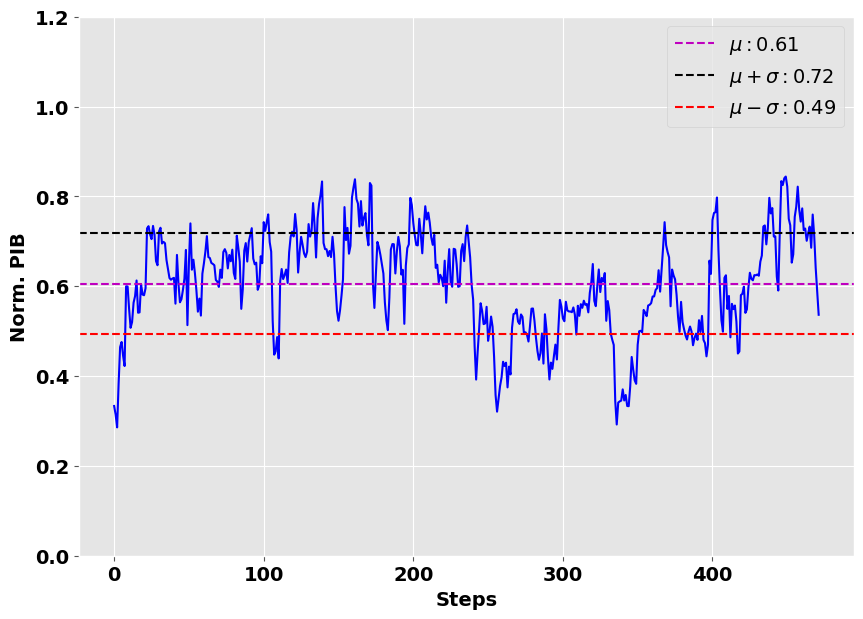

In [ ]:
plot_pib(pib_val,pib_n)

In [ ]:
P_n = np.zeros((7,7,n_img))
for idx in range(7):
  noise_env = env_pn(7*n_channel, cyc, delt)
  noise_env = np.transpose(noise_env)
  p_n = 2*noise_env-np.pi
  p_n[1,:] = 0
  # Random DC phase offset
  for i in range(7*n_channel):
    p_n[i,:] += np.pi*np.random.rand()
    # P_n[idx] = p_n
P_n = p_n.reshape(7,n_channel,p_n.shape[1])

NameError: ignored

In [ ]:
dic={'side_lobes':inner_pib.reshape(7,len(pib_val)),'pib':pib_val}
savemat('multi_sector.mat',dic)

In [ ]:
noise = np.zeros((7,n_channel))
# noise[3] = np.pi/2

In [ ]:
U_in,Up_f,I,UL,Xs,Ys,rPIBp,rp_lens = TiledAperture_2(im_size,pix_size,n_channel,noise,\
                                       n_screens,Kvar,7e3,trans_pn,atm,amp_v,g_amp,a,d,0,0.25,70e3)

In [ ]:
PIB(I,im_size/2,im_size/2,round(rPIBp),pix_size)/PIB(np.abs(U_in)**2,im_size/2,im_size/2,im_size/2,pix_size)

0.39555907326656975

In [ ]:
PIB(np.abs(U_in)**2,im_size/2,im_size/2,im_size/2,pix_size)

4594.752994625001

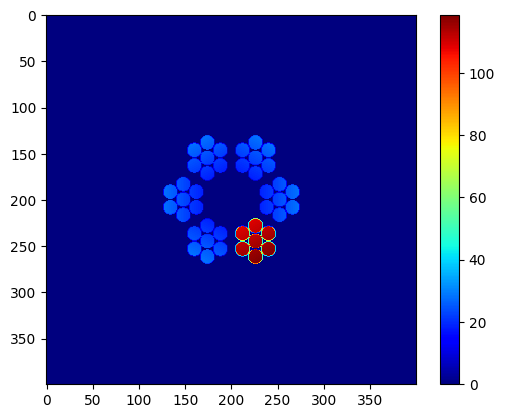

In [ ]:
xp = 200
plt.imshow(np.angle(U_in[im_size//2-xp:im_size//2+xp,im_size//2-xp:im_size//2+xp],deg=True),cmap='jet')
plt.colorbar()
plt.show()

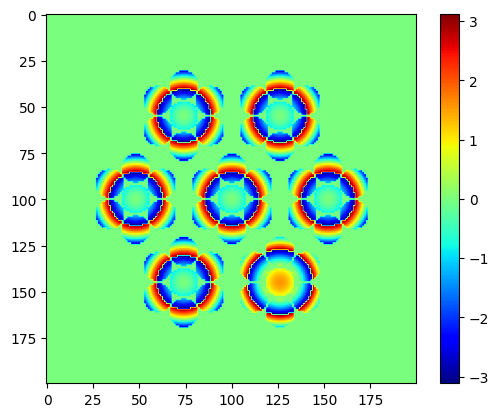

In [ ]:
xp = 100
plt.imshow(np.angle(Lens[im_size//2-xp:im_size//2+xp,im_size//2-xp:im_size//2+xp]),cmap='jet')
plt.colorbar()
plt.show()

In [ ]:
xs_idx = {'0':0,'1':2,'2':1,'3':6,'4':5,'5':4,'6':3}

In [ ]:
Xs,Ys

(array([  0,  52, -52,  26, -26,  26, -26], dtype=int16),
 array([  0,   0,   0,  45,  45, -45, -45], dtype=int16))

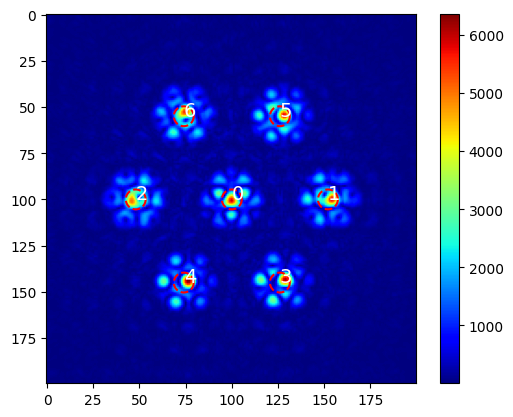

In [ ]:
xp = 100
new_UL = UL[im_size//2-xp:im_size//2+xp,im_size//2-xp:im_size//2+xp]
plt.imshow(np.abs(new_UL),cmap='jet')#[im_size//2-xp:im_size//2+xp,im_size//2-xp:im_size//2+xp]
plt.colorbar()
for idx in range(7):
  x = (new_UL.shape[0])/2+Xs[idx] + rp_lens*np.cos(theta)
  y = (new_UL.shape[0])/2+Ys[idx] + rp_lens*np.sin(theta)
  plt.plot(x,y,color='r',linestyle='dashed',linewidth=1.5)
  plt.text((new_UL.shape[0])/2+Xs[idx],(new_UL.shape[0])/2+Ys[idx],str(idx),color='white',fontsize=14)
plt.show()

In [ ]:
for idx in range(7):
  print(PIB(np.abs(UL)**2,im_size/2+Xs[idx],im_size/2+Ys[idx],rp_lens,pix_size))

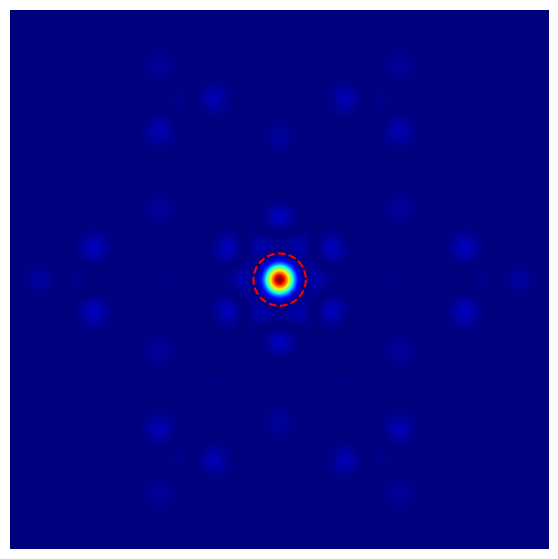

In [ ]:
theta = np.arange(0,2*np.pi+np.pi/36,np.pi/36)
x = (im_size)/2 + rPIBp*np.cos(theta)
y = (im_size)/2 + rPIBp*np.sin(theta)
plt.figure(figsize=(7,7))
plt.style.use('default')
plt.imshow(I,cmap='jet')
plt.plot(x,y,color='r',linestyle='dashed',linewidth=1.5)
# plt.colorbar()
plt.axis('off')
plt.show()